In [1]:
%%capture
!pip install osmnx networkx gpxpy

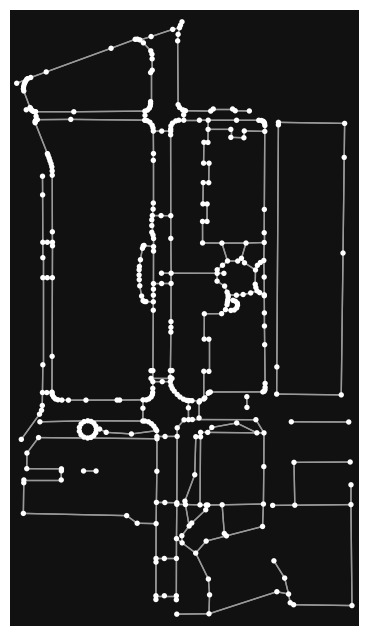

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [23]:
import osmnx as ox
import networkx as nx

def build_graph():
  graph = ox.graph.graph_from_place(
      "Vinhomes Times City, 458, Hai Ba Trung District, Hà Nội, 100000, Vietnam",
      network_type="walk",
      simplify=False,
      retain_all=True,
      custom_filter='["highway"~"footway"]',
  )
  return graph

pedestrian_G = build_graph()
ox.plot_graph(pedestrian_G)

In [24]:
start_lat, start_lon = 20.993779560986244, 105.86893358532133
start_node = ox.distance.nearest_nodes(pedestrian_G, X=start_lon, Y=start_lat)

In [30]:
def get_route(graph, start_node, visited_edges=None):
    if visited_edges is None:
        visited_edges = set()

    stack =[start_node]

    while stack:
        node = stack.pop()

        for neighbor in graph.neighbors(node):
            edge = tuple(sorted((node, neighbor)))

            if edge not in visited_edges:
                visited_edges.add(edge)

                edge_data = graph.get_edge_data(edge[0], edge[1])[0]
                stack.append(neighbor)

route = get_route(pedestrian_G, start_node)

In [31]:
import gpxpy
import gpxpy.gpx

def save_gpx(G, visited_edges, gpx_filename):
    # Create a new GPX file with a track and a segment
    gpx = gpxpy.gpx.GPX()
    gpx_track = gpxpy.gpx.GPXTrack()
    gpx.tracks.append(gpx_track)
    gpx_segment = gpxpy.gpx.GPXTrackSegment()
    gpx_track.segments.append(gpx_segment)

    # Iterate over each edge in the route
    for u, v in zip(route[:-1], route[1:]):
        edge_data = G.get_edge_data(u, v)

        if edge_data is None:
            continue  # Skip if no edge data is found between nodes u and v

        # Process each edge data entry (e.g., in case of multi-edges)
        for _, edge in edge_data.items():
            if 'geometry' in edge:  # Edge has geometry with multiple points
                for point in edge['geometry'].coords:
                    gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(point[1], point[0]))
            else:
                # Edge without geometry; use node coordinates directly
                node_u = G.nodes[u]
                node_v = G.nodes[v]
                gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(node_u['y'], node_u['x']))
                gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(node_v['y'], node_v['x']))

    # Write to the specified GPX file
    with open(gpx_filename, 'w') as gpx_file:
        gpx_file.write(gpx.to_xml())

save_gpx(pedestrian_G, route, 'route.gpx')

TypeError: 'NoneType' object is not subscriptable

In [32]:
import pandas as pd
import xml.etree.ElementTree as ET

def parse_gpx(filepath):
    root = ET.parse(filepath).getroot()
    ns = '{http://www.topografix.com/GPX/1/1}'

    data = {
        'lat': [],
        'lon': [],
    }
    for trk in root.findall(f".//{ns}trk"):
        for trkseg in trk.findall(f"{ns}trkseg"):
            for trkpt in trkseg.findall(f"{ns}trkpt"):
                data['lat'].append(float(trkpt.get('lat')))
                data['lon'].append(float(trkpt.get('lon')))

    df = pd.DataFrame(data)
    return df

df = parse_gpx('route.gpx')
df.head()

,lat,lon
0,20.993900,105.868977
1,20.993403,105.868983
2,20.993403,105.868983
3,20.993353,105.868983
4,20.993353,105.868983


In [33]:
import folium

m = folium.Map(
    location=(
      df['lat'].mean(),
      df['lon'].mean(),
    ),
    zoom_start=17,
)

def add_to_map(df, color):
    coordinates = df[['lat', 'lon']].values.tolist()
    folium.PolyLine(locations=coordinates, color=color, weight=5, opacity=1).add_to(m)

add_to_map(df, 'black')
m